In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client./
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=13eB6gNF1fWFiiVTTnF7QcK1iOJokJX8o' # The shareable link

In [3]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

13eB6gNF1fWFiiVTTnF7QcK1iOJokJX8o


In [0]:
import pandas as pd
import numpy as np
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('GSE26728_series_matrix.txt')  
data = pd.read_csv('GSE26728_series_matrix.txt', sep='\t')

## Как видим, первые 35 строк в датасете содержат общую информацию по эксперимету и оборудованию. Строка 35 содержит 18 столбцов, указывающие на конкретную мышь в конкретном эксперименте.
(3 эксперимента, 6 мышей в каждом)


In [5]:
data.head(38)

,!Sample_title,liver_control_rep1,liver_control_rep2,liver_control_rep3,liver_control_rep4,liver_control_rep5,liver_control_rep6,liver_BPALowDose_rep1,liver_BPALowDose_rep2,liver_BPALowDose_rep3,liver_BPALowDose_rep4,liver_BPALowDose_rep5,liver_BPALowDose_rep6,liver_BPAHighDose_rep1,liver_BPAHighDose_rep2,liver_BPAHighDose_rep3,liver_BPAHighDose_rep4,liver_BPAHighDose_rep5,liver_BPAHighDose_rep6
0,!Sample_geo_accession,GSM658075,GSM658076,GSM658077,GSM658078,GSM658079,GSM658080,GSM658081,GSM658082,GSM658083,GSM658084,GSM658085,GSM658086,GSM658087,GSM658088,GSM658089,GSM658090,GSM658091,GSM658092
1,!Sample_status,Public on Sep 21 2011,Public on Sep 21 2011,Public on Sep 21 2011,Public on Sep 21 2011,Public on Sep 21 2011,Public on Sep 21 2011,Public on Sep 21 2011,Public on Sep 21 2011,Public on Sep 21 2011,Public on Sep 21 2011,Public on Sep 21 2011,Public on Sep 21 2011,Public on Sep 21 2011,Public on Sep 21 2011,Public on Sep 21 2011,Public on Sep 21 2011,Public on Sep 21 2011,Public on Sep 21 2011
2,!Sample_submission_date,Jan 19 2011,Jan 19 2011,Jan 19 2011,Jan 19 2011,Jan 19 2011,Jan 19 2011,Jan 19 2011,Jan 19 2011,Jan 19 2011,Jan 19 2011,Jan 19 2011,Jan 19 2011,Jan 19 2011,Jan 19 2011,Jan 19 2011,Jan 19 2011,Jan 19 2011,Jan 19 2011
3,!Sample_last_update_date,Sep 23 2011,Sep 23 2011,Sep 23 2011,Sep 23 2011,Sep 23 2011,Sep 23 2011,Sep 23 2011,Sep 23 2011,Sep 23 2011,Sep 23 2011,Sep 23 2011,Sep 23 2011,Sep 23 2011,Sep 23 2011,Sep 23 2011,Sep 23 2011,Sep 23 2011,Sep 23 2011
4,!Sample_type,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA
5,!Sample_channel_count,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,!Sample_source_name_ch1,"liver, control, replicate 1","liver, control, replicate 2","liver, control, replicate 3","liver, control, replicate 4","liver, control, replicate 5","liver, control, replicate 6","liver, exposed to BPA at 50 µg/Kg/day, replica...","liver, exposed to BPA at 50 µg/Kg/day, replica...","liver, exposed to BPA at 50 µg/Kg/day, replica...","liver, exposed to BPA at 50 µg/Kg/day, replica...","liver, exposed to BPA at 50 µg/Kg/day, replica...","liver, exposed to BPA at 50 µg/Kg/day, replica...","liver, exposed to BPA at 5000 µg/Kg/day, repli...","liver, exposed to BPA at 5000 µg/Kg/day, repli...","liver, exposed to BPA at 5000 µg/Kg/day, repli...","liver, exposed to BPA at 5000 µg/Kg/day, repli...","liver, exposed to BPA at 5000 µg/Kg/day, repli...","liver, exposed to BPA at 5000 µg/Kg/day, repli..."
7,!Sample_organism_ch1,Mus musculus,Mus musculus,Mus musculus,Mus musculus,Mus musculus,Mus musculus,Mus musculus,Mus musculus,Mus musculus,Mus musculus,Mus musculus,Mus musculus,Mus musculus,Mus musculus,Mus musculus,Mus musculus,Mus musculus,Mus musculus
8,!Sample_characteristics_ch1,gender: male,gender: male,gender: male,gender: male,gender: male,gender: male,gender: male,gender: male,gender: male,gender: male,gender: male,gender: male,gender: male,gender: male,gender: male,gender: male,gender: male,gender: male
9,!Sample_characteristics_ch1,strain: CD-1,strain: CD-1,strain: CD-1,strain: CD-1,strain: CD-1,strain: CD-1,strain: CD-1,strain: CD-1,strain: CD-1,strain: CD-1,strain: CD-1,strain: CD-1,strain: CD-1,strain: CD-1,strain: CD-1,strain: CD-1,strain: CD-1,strain: CD-1


## Удалим первые 36 строк, оставив датасет, где по вертикали будут экспрессии определенного гена(признаки), а по горизонтали соответствующую этой экспрессии мышь(объект).

In [0]:
data2=data.iloc[35::]
data2=data2[:-1]
data2=data2[1:]
data2


## Проверим, не повторяются ли признаки в нашем датасете:

In [16]:
print('Количество уникальных генов: ',len(data2['!Sample_title'].unique()))

Количество уникальных генов:  22514


## Усредним экспрессии генов для каждой группы мышей:


In [0]:
controlcol=['!Sample_title']+list(data2.columns[1:7])
lowcol=['!Sample_title']+list(data2.columns[7:13])
highcol=['!Sample_title']+list(data2.columns[13:20])
#controlcol.append(['!Sample_title'])
#lowcol.append('!Sample_title')
#highcol.append('!Sample_title')

controlgroupmean=data2[controlcol]
controlgroupmean=controlgroupmean.set_index('!Sample_title')
controlgroupmean= controlgroupmean.astype(float)
controlgroupmean=controlgroupmean.mean(axis=1).to_frame().T
controlgroupmean['control']=1

lowmean=data2[lowcol]
lowmean=lowmean.set_index('!Sample_title')
lowmean= lowmean.astype(float)
lowmean=lowmean.mean(axis=1).to_frame().T
lowmean['control']=0

highmean=data2[highcol]
highmean=highmean.set_index('!Sample_title')
highmean= highmean.astype(float)
highmean=highmean.mean(axis=1).to_frame().T
highmean['control']=0

## Составим классификатор из дерева решений глубины 2 для групп: 
# control vs low_dose, и 
# control vs high_dose

[Text(167.4, 163.07999999999998, 'A_52_P79947 <= 10.086\ngini = 0.5\nsamples = 2\nvalue = [1, 1]\nclass = low'),
 Text(83.7, 54.360000000000014, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = control'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = low')]

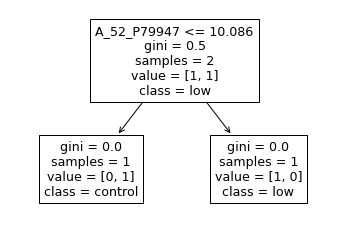

In [25]:
# control vs low_dose
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

classdata1=controlgroupmean.append(lowmean.loc[0])
model1=DecisionTreeClassifier(max_depth=2, random_state=4) # Зафиксируем random state, чтобы результат был воспроизводим
X=classdata1[classdata1.columns[:-1]]
y=classdata1.control
model1.fit(X,y)


tree.plot_tree(model1,max_depth=2,feature_names=classdata1.columns[:-1],class_names=['low','control'])

[Text(167.4, 163.07999999999998, 'A_52_P79947 <= 10.106\ngini = 0.5\nsamples = 2\nvalue = [1, 1]\nclass = high'),
 Text(83.7, 54.360000000000014, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = control'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = high')]

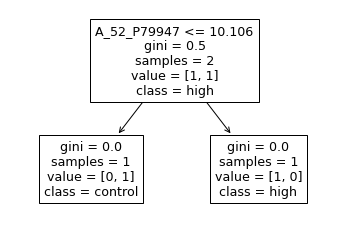

In [26]:
# control vs high_dose
classdata1=controlgroupmean.append(highmean.loc[0])
model2=DecisionTreeClassifier(max_depth=2, random_state=4) 
X=classdata1[classdata1.columns[:-1]]
y=classdata1.control
model2.fit(X,y)
tree.plot_tree(model2,max_depth=2,feature_names=classdata1.columns[:-1],class_names=['high','control'])

# Как видим, классы разделились по одному признаку(гену). Причем этот признак оказался решающим в обоих случаях




### Также попробуем применить PCA: 


In [28]:
data2=data.iloc[35::]
data2=data2[:-1]
data2=data2[1:]


traincolumns=['liver_control_rep1','liver_control_rep2','liver_control_rep3',
              'liver_BPALowDose_rep1','liver_BPALowDose_rep2','liver_BPALowDose_rep3',
              'liver_BPAHighDose_rep1','liver_BPAHighDose_rep2','liver_BPAHighDose_rep3']
testcolumns=['liver_control_rep6','liver_BPALowDose_rep6','liver_BPAHighDose_rep6',
             'liver_control_rep5','liver_control_rep4','liver_BPALowDose_rep4',
             'liver_BPALowDose_rep5','liver_BPAHighDose_rep4','liver_BPAHighDose_rep5']


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
data2=data2.set_index('!Sample_title')
data2=data2.astype(float)
X_train = data2[traincolumns]
X_test = data2[testcolumns]


pca = PCA()
#pca.fit_transform(X_train)
pca.fit_transform(data2)

print (pca.explained_variance_)


total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance/total < 0.9:
    current_variance += pca.explained_variance_[k]
    k = k + 1
    
print(k, " признак способен выявить различия между группами, в которых находились мыши.")

ERROR! Session/line number was not unique in database. History logging moved to new session 61
[9.09088177e+01 2.46063280e-01 1.85166449e-01 1.59378138e-01
 1.26523030e-01 1.09800842e-01 9.64571179e-02 8.67167890e-02
 7.84113343e-02 6.98500188e-02 6.44082751e-02 5.51198349e-02
 4.97110798e-02 4.71172282e-02 4.16635115e-02 3.75243683e-02
 3.66845743e-02 3.30883754e-02]
1  признак способен выявить различия между группами, в которых находились мыши.
